In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk
import itertools

import tqdm


sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification')
sys.path.insert(0, 'C:/Users/User/Code/MMD_Graph_Diversification/myKernels')
from myKernels import RandomWalk as rw
#from importlib import reload
#reload(readfoldertopanda)
import importlib
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
import WL
import GNTK
import GraphStatKernel
import WWL
import sp

In [2]:
import collections
import warnings

import numpy as np

from itertools import chain
from collections import Counter
from numbers import Real

from sklearn.utils import check_random_state
from sklearn.preprocessing import normalize as normalizer

from grakel.graph import Graph
from grakel.kernels import Kernel

# Python 2/3 cross-compatibility import
from six import itervalues
from six import iteritems
from six.moves import filterfalse


def _dot(x, y):
    return sum(x[k]*y[k] for k in x)

class Propagation(Kernel):
    r"""The Propagation kernel for fully labeled graphs.
    See :cite:`neumann2015propagation`: Algorithms 1, 3, p. 216, 221.
    Parameters
    ----------
    t_max : int, default=5
        Maximum number of iterations.
    w : int, default=0.01
        Bin width.
    M : str, default="TV"
        The preserved distance metric (on local sensitive hashing):
            - "H": hellinger
            - "TV": total-variation
    metric : function (Counter, Counter -> number),
        default=:math:`f(x,y)=\sum_{i} x_{i}*y_{i}`
        A metric between two 1-dimensional numpy arrays of numbers that outputs a number.
        It must consider the case where the keys of y are not in x, when different features appear
        at transform.
    random_state :  RandomState or int, default=None
        A random number generator instance or an int to initialize a RandomState as a seed.
    Attributes
    ----------
    _enum_labels : dict
        Holds the enumeration of the input labels.
    _parent_labels : set
        Holds a set of the input labels.
    random_state_ : RandomState
        A RandomState object handling all randomness of the class.
    """

    _graph_format = "adjacency"
    attr_ = False

    def __init__(self,
                 n_jobs=None,
                 verbose=False,
                 normalize=False,
                 random_state=None,
                 metric=_dot,
                 M="TV",
                 t_max=5,
                 w=0.01):
        """Initialise a propagation kernel."""
        super(Propagation, self).__init__(n_jobs=n_jobs,
                                          verbose=verbose,
                                          normalize=normalize)

        self.random_state = random_state
        self.M = M
        self.t_max = t_max
        self.w = w
        self.metric = metric
        self._initialized.update({"M": False, "t_max": False, "w": False,
                                  "random_state": False, "metric": False})

    def initialize(self):
        """Initialize all transformer arguments, needing initialization."""
        super(Propagation, self).initialize()

        if not self._initialized["random_state"]:
            self.random_state_ = check_random_state(self.random_state)
            self._initialized["random_state"] = True

        if not self._initialized["metric"]:
            if (type(self.M) is not str or
                    (self.M not in ["H", "TV"] and not self.attr_) or
                    (self.M not in ["L1", "L2"] and self.attr_)):
                if self.attr_:
                    raise TypeError('Metric type must be a str, one of "L1", "L2"')
                else:
                    raise TypeError('Metric type must be a str, one of "H", "TV"')

            if not self.attr_:
                self.take_sqrt_ = self.M == "H"

            self.take_cauchy_ = self.M in ["TV", "L1"]
            self._initialized["metric"] = True

        if not self._initialized["t_max"]:
            if type(self.t_max) is not int or self.t_max <= 0:
                raise TypeError('The number of iterations must be a ' +
                                'positive integer.')
            self._initialized["t_max"] = True

        if not self._initialized["w"]:
            if not isinstance(self.w, Real) and self.w <= 0:
                raise TypeError('The bin width must be a positive number.')
            self._initialized["w"] = True

        if not self._initialized["metric"]:
            if not callable(self.metric):
                raise TypeError('The base kernel must be callable.')
            self._initialized["metric"] = True

    def pairwise_operation(self, x, y):
        """Calculate the kernel value between two elements.
        Parameters
        ----------
        x, y: list
            Inverse label dictionaries.
        Returns
        -------
        kernel : number
            The kernel value.
        """
        return sum(self.metric(x[t], y[t]) for t in range(self.t_max))

    def parse_input(self, X):
        """Parse and create features for the propation kernel.
        Parameters
        ----------
        X : iterable
            For the input to pass the test, we must have:
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that correspond to the given
            graph format). A valid input also consists of graph type objects.
        Returns
        -------
        local_values : dict
            A dictionary of pairs between each input graph and a bins where the
            sampled graphlets have fallen.
        """
        if not isinstance(X, collections.Iterable):
            raise ValueError('input must be an iterable\n')
        else:
            i = -1
            transition_matrix = dict()
            labels = set()
            L = list()
            for (idx, x) in enumerate(iter(X)):
                is_iter = isinstance(x, collections.Iterable)
                if is_iter:
                    x = list(x)
                if is_iter and len(x) in [0, 2, 3, 4]:
                    if len(x) == 0:
                        warnings.warn('Ignoring empty element on ' +
                                      'index: '+str(idx))
                        continue
                    if len(x) == 2 and type(x[0]) is Graph:
                        g, T = x
                    else:
                        g = Graph(x[0], x[1], {}, self._graph_format)
                        if len(x) == 4:
                            T = x[3]
                        else:
                            T = None
                elif type(x) is Graph:
                    g, T = x, None
                else:
                    raise ValueError('Each element of X must be either a ' +
                                     'Graph or an iterable with at least 2 ' +
                                     'and at most 4 elements\n')

                if T is not None:
                    if T.shape[0] != T.shape[1]:
                        raise TypeError('Transition matrix on index' +
                                        ' ' + str(idx) + 'must be ' +
                                        'a square matrix.')
                    if T.shape[0] != g.nv():
                        raise TypeError('Propagation matrix must ' +
                                        'have the same dimension ' +
                                        'as the number of vertices.')
                else:
                    T = g.get_adjacency_matrix()

                i += 1
                transition_matrix[i] = normalizer(T, axis=1, norm='l1')
                label = g.get_labels(purpose='adjacency')
                try:
                    labels |= set(itervalues(label))
                except TypeError:
                    raise TypeError('For a non attributed kernel, labels should be hashable.')
                L.append((g.nv(), label))

            if i == -1:
                raise ValueError('Parsed input is empty')

            # The number of parsed graphs
            n = i+1

            # enumerate labels
            if self._method_calling == 1:
                enum_labels = {l: i for (i, l) in enumerate(list(labels))}
                self._enum_labels = enum_labels
                self._parent_labels = labels
            elif self._method_calling == 3:
                new_elements = labels - self._parent_labels
                if len(new_elements) > 0:
                    new_enum_labels = iter((l, i) for (i, l) in
                                           enumerate(list(new_elements), len(self._enum_labels)))
                    enum_labels = dict(chain(iteritems(self._enum_labels), new_enum_labels))
                else:
                    enum_labels = self._enum_labels

            # make a matrix for all graphs that contains label vectors
            P, data, indexes = dict(), list(), [0]
            for (k, (nv, label)) in enumerate(L):
                data += [(indexes[-1] + j, enum_labels[label[j]]) for j in range(nv)]
                indexes.append(indexes[-1] + nv)

            # Initialise the on hot vector
            rows, cols = zip(*data)
            P = np.zeros(shape=(indexes[-1], len(enum_labels)))
            P[rows, cols] = 1
            dim_orig = len(self._enum_labels)

            # feature vectors
            if self._method_calling == 1:
                # simple normal
                self._u, self._b, self._hd = list(), list(), list()
                for t in range(self.t_max):
                    u = self.random_state_.randn(len(enum_labels))

                    if self.take_cauchy_:
                        # cauchy
                        u = np.divide(u, self.random_state_.randn(len(enum_labels)))

                    self._u.append(u)
                    # random offset
                    self._b.append(self.w*self.random_state_.rand())

                phi = {k: dict() for k in range(n)}
                for t in range(self.t_max):
                    # for hash all graphs inside P and produce the feature vectors
                    hashes = self.calculate_LSH(P, self._u[t], self._b[t])
                    hd = dict((j, i) for i, j in enumerate(set(np.unique(hashes))))
                    self._hd.append(hd)
                    features = np.vectorize(lambda i: hd[i])(hashes)

                    # Accumulate the results.
                    for k in range(n):
                        phi[k][t] = Counter(features[indexes[k]:indexes[k+1]])

                    # calculate the Propagation matrix if needed
                    if t < self.t_max-1:
                        for k in range(n):
                            start, end = indexes[k:k+2]
                            P[start:end, :] = np.dot(transition_matrix[k], P[start:end, :])

                return [phi[k] for k in range(n)]

            elif (self._method_calling == 3 and dim_orig >= len(enum_labels)):
                phi = {k: dict() for k in range(n)}
                for t in range(self.t_max):
                    # for hash all graphs inside P and produce the feature vectors
                    hashes = self.calculate_LSH(P, self._u[t], self._b[t])
                    hd = dict(chain(
                            iteritems(self._hd[t]),
                            iter((j, i) for i, j in enumerate(
                                    filterfalse(lambda x: x in self._hd[t],
                                                np.unique(hashes)),
                                    len(self._hd[t])))))

                    features = np.vectorize(lambda i: hd[i])(hashes)

                    # Accumulate the results.
                    for k in range(n):
                        phi[k][t] = Counter(features[indexes[k]:indexes[k+1]])

                    # calculate the Propagation matrix if needed
                    if t < self.t_max-1:
                        for k in range(n):
                            start, end = indexes[k:k+2]
                            P[start:end, :] = np.dot(transition_matrix[k], P[start:end, :])

                return [phi[k] for k in range(n)]

            else:
                cols = np.array(cols)
                vertices = np.where(cols < dim_orig)[0]
                vertices_p = np.where(cols >= dim_orig)[0]
                nnv = len(enum_labels) - dim_orig
                phi = {k: dict() for k in range(n)}
                for t in range(self.t_max):
                    # hash all graphs inside P and produce the feature vectors
                    hashes = self.calculate_LSH(P[vertices, :dim_orig],
                                                self._u[t], self._b[t])

                    hd = dict(chain(
                            iteritems(self._hd[t]),
                            iter((j, i) for i, j in enumerate(
                                    filterfalse(lambda x: x in self._hd[t],
                                                np.unique(hashes)),
                                    len(self._hd[t])))))

                    features = np.vectorize(lambda i: hd[i], otypes=[int])(hashes)

                    # for each the new labels graph hash P and produce the feature vectors
                    u = self.random_state_.randn(nnv)
                    if self.take_cauchy_:
                        # cauchy
                        u = np.divide(u, self.random_state_.randn(nnv))

                    u = np.hstack((self._u[t], u))

                    # calculate hashes for the remaining
                    hashes = self.calculate_LSH(P[vertices_p, :], u, self._b[t])
                    hd = dict(chain(iteritems(hd), iter((j, i) for i, j in enumerate(hashes, len(hd)))))

                    features_p = np.vectorize(lambda i: hd[i], otypes=[int])(hashes)

                    # Accumulate the results
                    for k in range(n):
                        A = Counter(features[np.logical_and(
                            indexes[k] <= vertices, vertices <= indexes[k+1])])
                        B = Counter(features_p[np.logical_and(
                            indexes[k] <= vertices_p, vertices_p <= indexes[k+1])])
                        phi[k][t] = A + B

                    # calculate the Propagation matrix if needed
                    if t < self.t_max-1:
                        for k in range(n):
                            start, end = indexes[k:k+2]
                            P[start:end, :] = np.dot(transition_matrix[k], P[start:end, :])

                        Q = np.all(P[:, dim_orig:] > 0, axis=1)
                        vertices = np.where(~Q)[0]
                        vertices_p = np.where(Q)[0]

                return [phi[k] for k in range(n)]

    def calculate_LSH(self, X, u, b):
        """Calculate Local Sensitive Hashing needed for propagation kernels.
        See :cite:`neumann2015propagation`, p.12.
        Parameters
        ----------
        X : np.array
            A float array of shape (N, D) with N vertices and D features.
        u : np.array, shape=(D, 1)
            A projection vector.
        b : float
            An offset (times w).
        Returns
        -------
        lsh : np.array.
            The local sensitive hash coresponding to each vertex.
        """
        if self.take_sqrt_:
            X = np.sqrt(X)

        # hash
        return np.floor((np.dot(X, u)+b)/self.w)

class PropagationAttr(Propagation):
    r"""The Propagation kernel for fully attributed graphs.
    See :cite:`neumann2015propagation`: Algorithms 1, 3, p. 216, 221.
    Parameters
    ----------
    t_max : int, default=5
        Maximum number of iterations.
    w : int, default=0.01
        Bin width.
    M : str, default="TV"
        The preserved distance metric (on local sensitive hashing):
            - "L1": l1-norm
            - "L2": l2-norm
    metric : function (np.array, np.array -> number),
        default=:math:`f(x,y)=\sum_{i} x_{i}*y_{i}`
        A metric between two 1-dimensional numpy arrays of numbers
        that outputs a number.
    Attributes
    ----------
    M : str
        The preserved distance metric (on local sensitive hashing).
    tmax : int
        Holds the maximum number of iterations.
    w : int
        Holds the bin width.
    metric : function (np.array, np.array -> number)
        A metric between two 1-dimensional numpy arrays of numbers
        that outputs a number.
    """

    _graph_format = "adjacency"
    attr_ = True

    def __init__(self,
                 n_jobs=None,
                 verbose=False,
                 normalize=False,
                 random_state=None,
                 metric=_dot,
                 M="L1",
                 t_max=5,
                 w=4):
        """Initialise a propagation kernel."""
        super(PropagationAttr, self).__init__(n_jobs=n_jobs,
                                              verbose=verbose,
                                              normalize=normalize,
                                              random_state=random_state,
                                              metric=metric,
                                              M=M,
                                              t_max=t_max,
                                              w=w)

    def initialize(self):
        """Initialize all transformer arguments, needing initialization."""
        super(PropagationAttr, self).initialize()

    def parse_input(self, X):
        """Parse and create features for the attributed propation kernel.
        Parameters
        ----------
        X : iterable
            For the input to pass the test, we must have:
            Each element must be an iterable with at most three features and at
            least one. The first that is obligatory is a valid graph structure
            (adjacency matrix or edge_dictionary) while the second is
            node_labels and the third edge_labels (that correspond to the given
            graph format). A valid input also consists of graph type objects.
        Returns
        -------
        local_values : dict
            A dictionary of pairs between each input graph and a bins where the
            sampled graphlets have fallen.
        """
        if not isinstance(X, collections.Iterable):
            raise ValueError('input must be an iterable\n')
        else:
            # The number of parsed graphs
            n = 0
            transition_matrix = dict()
            indexes = [0]
            Attr = list()
            for (idx, x) in enumerate(iter(X)):
                is_iter = isinstance(x, collections.Iterable)
                if is_iter:
                    x = list(x)
                if is_iter and len(x) in [0, 2, 3, 4]:
                    if len(x) == 0:
                        warnings.warn('Ignoring empty element on ' +
                                      'index: '+str(idx))
                        continue
                    if len(x) == 2 and type(x[0]) is Graph:
                        g, T = x
                    else:
                        g = Graph(x[0], x[1], {}, self._graph_format)
                        if len(x) == 4:
                            T = x[3]
                        else:
                            T = None
                elif type(x) is Graph:
                    g, T = x, None
                else:
                    raise ValueError('Each element of X must be either a ' +
                                     'Graph or an iterable with at least 2 ' +
                                     'and at most 4 elements\n')

                if T is not None:
                    if T.shape[0] != T.shape[1]:
                        raise TypeError('Transition matrix on index' +
                                        ' ' + str(idx) + 'must be ' +
                                        'a square matrix.')
                    if T.shape[0] != g.nv():
                        raise TypeError('Propagation matrix must ' +
                                        'have the same dimension ' +
                                        'as the number of vertices.')
                else:
                    T = g.get_adjacency_matrix()

                nv = g.nv()
                transition_matrix[n] = normalizer(T, axis=1, norm='l1')
                attr = g.get_labels(purpose="adjacency")
                try:
                    attributes = np.array([attr[j] for j in range(nv)])
                except TypeError:
                    raise TypeError('All attributes of a single graph should have the same dimension.')

                Attr.append(attributes)
                indexes.append(indexes[-1] + nv)
                n += 1
            try:
                P = np.vstack(Attr)
            except ValueError:
                raise ValueError('Attribute dimensions should be the same, for all graphs')

            if self._method_calling == 1:
                self._dim = P.shape[1]
            else:
                if self._dim != P.shape[1]:
                    raise ValueError('transform attribute vectors should'
                                     'have the same dimension as in fit')

            if n == 0:
                raise ValueError('Parsed input is empty')

            # feature vectors
            if self._method_calling == 1:
                # simple normal
                self._u, self._b, self._hd = list(), list(), list()
                for t in range(self.t_max):
                    u = self.random_state_.randn(self._dim)
                    if self.take_cauchy_:
                        # cauchy
                        u = np.divide(u, self.random_state_.randn(self._dim))

                    self._u.append(u)
                    # random offset
                    self._b.append(self.w*self.random_state_.randn(self._dim))

                phi = {k: dict() for k in range(n)}
                for t in range(self.t_max):
                    # for hash all graphs inside P and produce the feature vectors
                    hashes = self.calculate_LSH(P, self._u[t], self._b[t]).tolist()

                    hd = {j: i for i, j in enumerate({tuple(l) for l in hashes})}
                    self._hd.append(hd)

                    features = np.array([hd[tuple(l)] for l in hashes])

                    # Accumulate the results.
                    for k in range(n):
                        phi[k][t] = Counter(features[indexes[k]:indexes[k+1]].flat)

                    # calculate the Propagation matrix if needed
                    if t < self.t_max-1:
                        for k in range(n):
                            start, end = indexes[k:k+2]
                            P[start:end, :] = np.dot(transition_matrix[k], P[start:end, :])

                return [phi[k] for k in range(n)]

            if self._method_calling == 3:
                phi = {k: dict() for k in range(n)}
                for t in range(self.t_max):
                    # for hash all graphs inside P and produce the feature vectors
                    hashes = self.calculate_LSH(P, self._u[t], self._b[t]).tolist()

                    hd = dict(chain(
                            iteritems(self._hd[t]),
                            iter((j, i) for i, j in enumerate(
                                    filterfalse(lambda x: x in self._hd[t],
                                                {tuple(l) for l in hashes}),
                                    len(self._hd[t])))))

                    features = np.array([hd[tuple(l)] for l in hashes])

                    # Accumulate the results.
                    for k in range(n):
                        phi[k][t] = Counter(features[indexes[k]:indexes[k+1]])

                    # calculate the Propagation matrix if needed
                    if t < self.t_max-1:
                        for k in range(n):
                            start, end = indexes[k:k+2]
                            P[start:end, :] = np.dot(transition_matrix[k], P[start:end, :])

                return [phi[k] for k in range(n)]

    def calculate_LSH(self, X, u, b):
        """Calculate Local Sensitive Hashing needed for propagation kernels.
        See :cite:`neumann2015propagation`, p.12.
        Parameters
        ----------
        X : np.array
            A float array of shape (N, D) with N vertices and D features.
        u : np.array, shape=(D, 1)
            A projection vector.
        b : float
            An offset (times w).
        Returns
        -------
        lsh : np.array.
            The local sensitive hash coresponding to each vertex.
        """
        return np.floor((X*u+b)/self.w)




# TEST

Generate graphs

In [10]:
from importlib import reload  
foo = reload(mg)

n_1 = 20
n_2 = 20
nnode_1 = 143
nnode_2 = 143

bg1 = mg.BinomialGraphs(n_1, nnode_1, k = 4, fullyConnected = True, l = 'degreelabels')
bg2 = mg.BinomialGraphs(n_2, nnode_2, k = 4, fullyConnected = True, l = 'degreelabels')
bg1.Generate()
bg2.Generate()



In [33]:

G1 = bg1.Gs.copy()
G2 = bg2.Gs.copy()

def edge_dist(loc = 0.8, scale = 0.2):
    from scipy.stats import uniform
    return np.random.exponential(scale = scale)# uniform.rvs(size=1,  loc = loc , scale = scale)[0]
def add_weight(G, loc = 0.75, scale = 0.2):
    edge_w = dict()
    for e in G.edges():
        edge_w[e] = edge_dist(loc, scale)
    return edge_w


def edge_dist2(loc = 0.8, scale = 0.2):
    from scipy.stats import uniform
    return np.random.normal(loc = loc, scale = scale)# uniform.rvs(size=1,  loc = loc , scale = scale)[0]
def add_weight2(G, loc = 0.75, scale = 0.2):
    edge_w = dict()
    for e in G.edges():
        edge_w[e] = edge_dist2(loc, scale)
    return edge_w


# for G in G1:

for G in G1:
    nx.set_edge_attributes(G, add_weight(G, loc = 3000, scale = 1000), "weight")
for G in G2:
    nx.set_edge_attributes(G, add_weight(G, loc = 3000, scale = 1000), "weight")

for G in G1:
    nx.set_node_attributes(G, {i:np.random.normal(size=(1,), loc = 0.00038, scale= 0.01) for i in range(nnode_1)}, "attr")
for G in G2:
    nx.set_node_attributes(G, {i:np.random.normal(size=(1,), loc = 0.00038, scale= 0.02) for i in range(nnode_1)}, "attr")


for G in G1:
    nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")
for G in G2:
    nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")


Gs = G1+G2
p = [np.resize(list(nx.get_node_attributes(G, 'attr').values()), new_shape = (20)) for G in Gs]
#print("Graph preperation done...")   
MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments = [dict(n = bg1.n, m = bg1.n  ), 
            dict(n = bg1.n, m = bg1.n ),
            dict(n = bg1.n, m = bg1.n )]#, 
            #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]




def prepare_gs_for_sp(Gs, round_edge, round_node):
    
    Gs_new  = []

    max_weight = 0
    for i in range(len(Gs)):
        max_weight_i = np.max([np.abs(w[2]) for w in Gs[i].edges(data = 'weight')])
        if max_weight_i > max_weight:
            max_weight = np.abs(max_weight_i)

    max_return = 0

    for i in range(len(Gs)):
        max_return_i = np.max([w[1] for w in Gs[i].nodes(data = 'attr')])
        if max_weight_i > max_return:
            max_return = np.abs(max_return_i)
            
    for i in range(len(Gs)):

        Gs_new.append(nx.from_numpy_array(np.abs(np.round(nx.adjacency_matrix(Gs[i]).todense()/max_weight, round_edge))))
        nx.set_node_attributes(Gs_new[i], {v:str(np.round(w[0]/max_return,round_node)) for v, w in nx.get_node_attributes(Gs[0], 'attr').items()}, 'label')

    return Gs_new






Gs_wl =   prepare_gs_for_sp(Gs, 1, 1)

kernel = [{"name": "WL-OA", "n_iter": 2}]
init_kernel = gk.GraphKernel(kernel= kernel, normalize=0)
gk_gs = gk.graph_from_networkx(Gs_wl, node_labels_tag='label')
K = init_kernel.fit_transform(gk_gs)
kernel_hypothesis.Bootstrap(K, function_arguments, B = 5000)
kernel_hypothesis.p_values


C:\Users\User\AppData\Local\Temp\ipykernel_29960\3458534739.py:75: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Gs_new.append(nx.from_numpy_array(np.abs(np.round(nx.adjacency_matrix(Gs[i]).todense()/max_weight, round_edge))))


{'MMD_b': 0.8004, 'MMD_u': 0.799, 'MMD_l': 0.5498}

In [34]:
nx.get_node_attributes(Gs_wl[0], 'label')

{0: '0.0',
 1: '-0.0',
 2: '-0.0',
 3: '0.2',
 4: '0.3',
 5: '-0.0',
 6: '0.3',
 7: '0.1',
 8: '0.3',
 9: '0.0',
 10: '0.0',
 11: '-0.1',
 12: '-0.2',
 13: '0.0',
 14: '-0.1',
 15: '-0.1',
 16: '-0.1',
 17: '-0.1',
 18: '-0.1',
 19: '-0.0',
 20: '-0.0',
 21: '0.3',
 22: '0.0',
 23: '-0.1',
 24: '0.1',
 25: '-0.1',
 26: '-0.3',
 27: '0.2',
 28: '-0.2',
 29: '0.2',
 30: '-0.1',
 31: '0.0',
 32: '-0.2',
 33: '0.1',
 34: '-0.1',
 35: '-0.1',
 36: '0.1',
 37: '0.2',
 38: '0.2',
 39: '0.1',
 40: '0.0',
 41: '0.1',
 42: '-0.0',
 43: '0.1',
 44: '-0.1',
 45: '-0.1',
 46: '0.3',
 47: '0.3',
 48: '-0.1',
 49: '-0.2',
 50: '-0.2',
 51: '-0.0',
 52: '0.0',
 53: '-0.1',
 54: '0.0',
 55: '0.0',
 56: '0.2',
 57: '0.1',
 58: '-0.0',
 59: '-0.1',
 60: '-0.1',
 61: '0.1',
 62: '0.2',
 63: '-0.1',
 64: '-0.1',
 65: '0.0',
 66: '0.1',
 67: '-0.1',
 68: '-0.0',
 69: '0.0',
 70: '-0.0',
 71: '-0.3',
 72: '0.1',
 73: '0.0',
 74: '0.3',
 75: '0.3',
 76: '0.3',
 77: '-0.0',
 78: '-0.0',
 79: '0.0',
 80: '-0.2'

<AxesSubplot:>

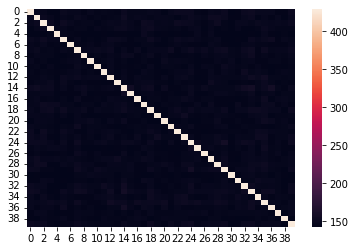

In [30]:
sns.heatmap(K)

In [35]:
prop_w = [0.1, 0.01, 0.001, 0.0001]
pyramid_L = [2,6,10]
wl_itr = [2,4]

scale2 = 3000
p2 = 0.45
B = 3000
loc_attr = 0.00038
scale_attr = 0.01
import tqdm

out_p_val = {'rw_weight':[],
            'rw_signed':[],
            'sp':[],
            'rw_binary':[],
            'rw_abs':[],
            'Bonferroni':[],
            'Tensor':[]}

for w in prop_w:
    out_p_val['propagation' + str(w)] = []
    out_p_val['wwl' + str(w)] = []

for w in prop_w:
    out_p_val['propagation' + str(w)] = []

for L in pyramid_L:
    out_p_val['pyramid' + str(L)+'wlab'] = []
    out_p_val['pyramid' + str(L)] = []

for h in wl_itr:
    out_p_val['wl' + str(h)] = []
    out_p_val['wloa' + str(h)] = []


for _ in tqdm.tqdm(range(1)):
    bg1.Generate()
    bg2.Generate()
    # Add weights
    def edge_dist( scale ):
        from scipy.stats import uniform
        return np.random.exponential(scale = scale)# uniform.rvs(size=1,  loc = loc , scale = scale)[0]
    def add_weight(G, scale ):
        edge_w = dict()
        for e in G.edges():
            edge_w[e] = edge_dist(scale)
        return edge_w

    G1 = bg1.Gs.copy()
    G2 = bg2.Gs.copy()

    for G in G1:
        nx.set_edge_attributes(G, add_weight(G, scale = 3000), "weight")
    for G in G2:
        nx.set_edge_attributes(G, add_weight(G, scale =scale2), "weight")

    for G in G1:
        nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")
    for G in G2:
        nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")


    for G in G1:
        for e in G.edges():
            if np.random.uniform() <0.3:
                w = G.edges[e[0], e[1]]['weight']
                G.edges[e[0], e[1]]['weight'] = -w

    for G in G2:
        for e in G.edges():
            if np.random.uniform() < p2:
                w = G.edges[e[0], e[1]]['weight']
                G.edges[e[0], e[1]]['weight'] = -w

    for G in G1:
        nx.set_edge_attributes(G, {(n1, n2): np.sign(w) for n1, n2, w in G.edges().data('weight')}, "sign")
    for G in G2:
        nx.set_edge_attributes(G, {(n1, n2): np.sign(w) for n1, n2, w in G.edges().data('weight')}, "sign")

    for G in G1:
        nx.set_node_attributes(G, {i:100*np.random.normal(size = (1,), loc = 0.00038, scale= 0.01) for i in range(G.number_of_nodes())}, "attr")
    for G in G2:
        nx.set_node_attributes(G, {i:100*np.random.normal(size = (1,), loc = loc_attr, scale= scale_attr) for i in range(G.number_of_nodes())}, "attr")


    Gs = G1 + G2

    Gs_abs = [nx.from_numpy_array(np.abs(nx.adjacency_matrix(G))) for G in Gs]
    Gs_binary = [nx.from_numpy_array(np.sign(nx.adjacency_matrix(G).todense())) for G in Gs]
    Gs_plus = []
    Gs_negative = []
    for i in range(len(Gs)):
        A = nx.adjacency_matrix(Gs[i]).todense()
        A_plus = A.copy()
        A_plus[A_plus<0] =0
        Gs_plus.append(nx.from_numpy_array(A_plus))
        nx.set_node_attributes(Gs_plus[i], nx.get_node_attributes(Gs[i], 'attr'), "attr")
        nx.set_node_attributes(Gs_plus[i], {j:str(k) for j,k in Gs[i].degree}, "label")


        A_negative = A.copy()
        A_negative[A_negative>0] =0
        A_negative = np.abs(A_negative)
        Gs_negative.append(nx.from_numpy_array(A_negative))
        nx.set_node_attributes(Gs_negative[i], nx.get_node_attributes(Gs[i], 'attr'), "attr")
        nx.set_node_attributes(Gs_negative[i], {j:str(k) for j,k in Gs[i].degree}, "label")


    p = [np.resize(list(nx.get_node_attributes(G, 'attr').values()), new_shape = (20)) for G in Gs]
    #print("Graph preperation done...")
    MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    function_arguments = [dict(n = bg1.n, m = bg1.n  ),
                dict(n = bg1.n, m = bg1.n ),
                dict(n = bg1.n, m = bg1.n )]#,
                #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]


    # def edge_kernel(x,y):
    #     return np.exp(-0.01*np.abs(x-y))
    # my_sp = sp.sp_kernel(weight = 'weight', edge_kernel= edge_kernel)
    # K_plus = my_sp.fit_transform(Gs_plus,verbose = False)
    # K_negative = my_sp.fit_transform(Gs_negative,verbose = False)
    # K = np.multiply(K_plus, K_negative)
    # v,_ = np.linalg.eigh(K)
    # if np.any(v < -10e-8):
    #     raise ValueError("Not psd sp")

    # kernel_hypothesis.Bootstrap(K, function_arguments, B = B)
    # kernel_hypothesis.p_values

    rw_kernel = rw.RandomWalk(Gs, c = 1e-9, normalize=0, p = p , q = p)
    K_rw = rw_kernel.fit_ARKU_plus(r=6, verbose = False, edge_attr='weight')
    v,_ = np.linalg.eigh(K_rw)
    if np.any(v < -10e-8):
        raise ValueError("Not psd")
    kernel_hypothesis.Bootstrap(K_rw, function_arguments, B = B)
    out_p_val['rw_weight'].append(kernel_hypothesis.p_values["MMD_u"])
    # print(f'p_value {kernel_hypothesis.p_values["MMD_u"]}')


    # for w in prop_w:
    #     prop = PropagationAttr(w = w,t_max = 4)
    #     gk_gs = gk.graph_from_networkx(Gs_plus, edge_weight_tag='weight',  node_labels_tag = 'attr')
    #     K_plus = prop.fit_transform(gk_gs)

    #     prop = PropagationAttr(w = w,t_max = 4)
    #     gk_gs = gk.graph_from_networkx(Gs_negative, edge_weight_tag='weight',  node_labels_tag = 'attr')
    #     K_negative = prop.fit_transform(gk_gs)

    #     K = np.multiply(K_plus, K_negative)
    #     v,_ = np.linalg.eigh(K)
    #     if np.any(v < -10e-8):
    #         raise ValueError("Not psd prop")

    #     kernel_hypothesis.Bootstrap(K, function_arguments, B = B)
    #     out_p_val['propagation' + str(w)].append(kernel_hypothesis.p_values["MMD_u"])
out_p_val

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_18404\1020799244.py:88: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Gs_abs = [nx.from_numpy_array(np.abs(nx.adjacency_matrix(G))) for G in Gs]
C:\Users\User\AppData\Local\Temp\ipykernel_18404\1020799244.py:89: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Gs_binary = [nx.from_numpy_array(np.sign(nx.adjacency_matrix(G).todense())) for G in Gs]
C:\Users\User\AppData\Local\Temp\ipykernel_18404\1020799244.py:93: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(Gs[i]).todense()
100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


{'rw_weight': [0.118],
 'rw_signed': [],
 'sp': [],
 'rw_binary': [],
 'rw_abs': [],
 'Bonferroni': [],
 'Tensor': [],
 'propagation0.1': [],
 'wwl0.1': [],
 'propagation0.01': [],
 'wwl0.01': [],
 'propagation0.001': [],
 'wwl0.001': [],
 'propagation0.0001': [],
 'wwl0.0001': [],
 'pyramid2wlab': [],
 'pyramid2': [],
 'pyramid6wlab': [],
 'pyramid6': [],
 'pyramid10wlab': [],
 'pyramid10': [],
 'wl2': [],
 'wloa2': [],
 'wl4': [],
 'wloa4': []}

<AxesSubplot:>

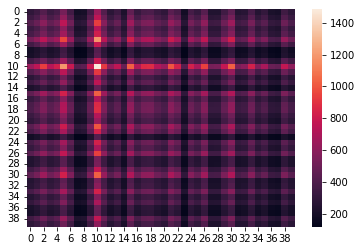

In [36]:
sns.heatmap(K_rw)

# Weight attr test

In [80]:
loc_attr = 0.01
scale_attr = 0.012
N = 1
scale2 = 4000
B = 1000 

prop_w = [0.1, 0.01, 0.001, 0.0001]
pyramid_L = [2,6,10]
wl_itr = [2,4]

out_p_val = {'rw_weight':[],
            'rw_weight2':[],
            'sp':[],
            'rw_binary':[],
            'rw_binary2':[]}

for w in prop_w:
    out_p_val['propagation' + str(w)] = []
    out_p_val['wwl' + str(w)] = []

for w in prop_w:
    out_p_val['propagation' + str(w)] = []

for L in pyramid_L:
    out_p_val['pyramid' + str(L)+'wlab'] = []
    out_p_val['pyramid' + str(L)] = []

for h in wl_itr:
    out_p_val['wl' + str(h)] = []
    out_p_val['wloa' + str(h)] = []


for _ in tqdm.tqdm(range(N)):
    bg1.Generate()
    bg2.Generate()
    # Add weights
    def edge_dist( scale ):
        from scipy.stats import uniform
        return np.random.exponential(scale = scale)# uniform.rvs(size=1,  loc = loc , scale = scale)[0]
    def add_weight(G, scale ):
        edge_w = dict()
        for e in G.edges():
            edge_w[e] = edge_dist(scale)
        return edge_w

    G1 = bg1.Gs.copy()
    G2 = bg2.Gs.copy()

    for G in G1:
        nx.set_edge_attributes(G, add_weight(G, scale = 3000), "weight")
    for G in G2:
        nx.set_edge_attributes(G, add_weight(G, scale =scale2), "weight")

    for G in G1:
        nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")
    for G in G2:
        nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")

    for G in G1:
        nx.set_node_attributes(G, {i:np.random.normal(size = (1,), loc = 0.01, scale= 0.01) for i in range(G.number_of_nodes())}, "attr")
    for G in G2:
        nx.set_node_attributes(G, {i:np.random.normal(size = (1,), loc = loc_attr, scale= scale_attr) for i in range(G.number_of_nodes())}, "attr")

            
    Gs = G1 + G2

    p = [np.resize(list(nx.get_node_attributes(G, 'attr').values()), new_shape = (20)) for G in Gs]
    

    #print("Graph preperation done...")   
    MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    function_arguments = [dict(n = bg1.n, m = bg1.n  ), 
                dict(n = bg1.n, m = bg1.n ),
                dict(n = bg1.n, m = bg1.n )]#, 
                #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]


    #print("RW as-is")
    rw_kernel = rw.RandomWalk(Gs, c = 1e-10, normalize=0, p = p)
    K_rw = rw_kernel.fit_ARKU_plus(r=6, verbose = False, edge_attr='weight')
    v,_ = np.linalg.eigh(K_rw)
    if np.any(v < -10e-8):
        raise ValueError("Not psd")
    kernel_hypothesis.Bootstrap(K_rw, function_arguments, B = B)
    print(kernel_hypothesis.p_values)
    # print(f'p_value {kernel_hypothesis.p_values["MMD_u"]}')

    rw_kernel = rw.RandomWalk(Gs, c = 1e-10, normalize=0, p = p, q = p)
    K_rw = rw_kernel.fit_ARKU_plus(r=6, verbose = False, edge_attr='weight')
    v,_ = np.linalg.eigh(K_rw)
    if np.any(v < -10e-8):
        raise ValueError("Not psd")
    kernel_hypothesis.Bootstrap(K_rw, function_arguments, B = B)
    print(kernel_hypothesis.p_values)
    # print(f'p_value {kernel_hypothesis.p_values["MMD_u"]}')

    # def edge_kernel(x,y):
    #     return np.exp(-0.01*np.abs(x-y))
    # def node_kernel(x,y):
    #     return np.exp(-1000*np.abs(x-y))
    # my_sp = sp.sp_kernel(weight = 'weight', with_labels = True,  edge_kernel = edge_kernel, node_kernel = node_kernel)
    # K = my_sp.fit_transform(G1+G2,verbose = False)
    # v,_ = np.linalg.eigh(K)
    # if np.any(v < -10e-8):
    #     raise ValueError("Not psd")
    # kernel_hypothesis.Bootstrap(K, function_arguments, B = B)
    # print(kernel_hypothesis.p_values)

  0%|          | 0/1 [00:00<?, ?it/s]

{'MMD_b': 0.176, 'MMD_u': 0.176, 'MMD_l': 0.093}


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

{'MMD_b': 0.001, 'MMD_u': 0.001, 'MMD_l': 0.004}


In [37]:
def edge_kernel(x,y):
    return np.exp(-1000*np.abs(x-y))

edge_kernel(0.00038,0.00018)

0.8187307530779818

# Test same graphs

In [188]:
loc_attr = 0.00038
scale_attr = 0.015
N = 1


prop_w = [0.1, 0.01, 0.001, 0.0001]
pyramid_L = [2,6,10]
wl_itr = [2,4]

out_p_val = {'rw_weight':[],
            'rw_weight2':[],
            'sp':[],
            'rw_binary':[],
            'rw_binary2':[]}

for w in prop_w:
    out_p_val['propagation' + str(w)] = []
    out_p_val['wwl' + str(w)] = []

for w in prop_w:
    out_p_val['propagation' + str(w)] = []

for L in pyramid_L:
    out_p_val['pyramid' + str(L)+'wlab'] = []
    out_p_val['pyramid' + str(L)] = []

for h in wl_itr:
    out_p_val['wl' + str(h)] = []
    out_p_val['wloa' + str(h)] = []


for _ in tqdm.tqdm(range(N)):
    bg1.Generate()
    bg2.Generate()
    # Add weights
    def edge_dist( scale ):
        from scipy.stats import uniform
        return np.random.exponential(scale = scale)# uniform.rvs(size=1,  loc = loc , scale = scale)[0]
    def add_weight(G, scale ):
        edge_w = dict()
        for e in G.edges():
            edge_w[e] = edge_dist(scale)
        return edge_w

    G1 = bg1.Gs.copy()
    G2 = bg2.Gs.copy()

    for G in G1:
        nx.set_edge_attributes(G, add_weight(G, scale = 3000), "weight")
    for G in G2:
        nx.set_edge_attributes(G, add_weight(G, scale =scale2), "weight")

    for G in G1:
        nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")
    for G in G2:
        nx.set_node_attributes(G, {i:str(k) for i,k in G.degree}, "label")

    for G in G1:
        nx.set_node_attributes(G, {i:np.random.normal(size = (1,), loc = 0.00038, scale= 0.01) for i in range(G.number_of_nodes())}, "attr")
    for G in G2:
        nx.set_node_attributes(G, {i:np.random.normal(size = (1,), loc = loc_attr, scale= scale_attr) for i in range(G.number_of_nodes())}, "attr")

            
    Gs = G1 + G2

    p = [np.resize(list(nx.get_node_attributes(G, 'attr').values()), new_shape = (20)) for G in Gs]
    

    #print("Graph preperation done...")   
    MMD_functions = [mg.MMD_b, mg.MMD_u, mg.MMD_l]#, mg.MONK_EST]
    kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
    function_arguments = [dict(n = bg1.n, m = bg1.n  ), 
                dict(n = bg1.n, m = bg1.n ),
                dict(n = bg1.n, m = bg1.n )]#, 
                #dict(Q = 3, y1 = Gs[:bg1.n], y2 = Gs[bg1.n:] )]


    #print("RW as-is")
    rw_kernel = rw.RandomWalk(Gs, c = 1e-10, normalize=0, p = p)
    K_rw = rw_kernel.fit_ARKU_plus(r=6, verbose = False, edge_attr='weight')
    v,_ = np.linalg.eigh(K_rw)
    if np.any(v < -10e-8):
        raise ValueError("Not psd")
    kernel_hypothesis.Bootstrap(K_rw, function_arguments, B = B)
    out_p_val['rw_weight'].append(kernel_hypothesis.p_values["MMD_u"])
    # print(f'p_value {kernel_hypothesis.p_values["MMD_u"]}')

    rw_kernel = rw.RandomWalk(Gs, c = 1e-10, normalize=0, p = p, q = p)
    K_rw = rw_kernel.fit_ARKU_plus(r=6, verbose = False, edge_attr='weight')
    v,_ = np.linalg.eigh(K_rw)
    if np.any(v < -10e-8):
        raise ValueError("Not psd")
    kernel_hypothesis.Bootstrap(K_rw, function_arguments, B = B)
    out_p_val['rw_weight2'].append(kernel_hypothesis.p_values["MMD_u"])
    # print(f'p_value {kernel_hypothesis.p_values["MMD_u"]}')

C:\Users\User\AppData\Local\Temp\ipykernel_29316\1655437825.py:50: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Gs_abs = [nx.from_numpy_array(np.abs(nx.adjacency_matrix(G))) for G in Gs]
C:\Users\User\AppData\Local\Temp\ipykernel_29316\1655437825.py:54: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(Gs[i]).todense()
C:/Users/User/Code/MMD_Graph_Diversification\myKernels\RandomWalk.py:900: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return scipy.sparse.csr_matrix(nx.adjacency_matrix(G ,weight=edge_attr), dtype=np.float64)
C:/Users/User/Code/MMD_Graph_Diversification\myKernels\RandomWalk.py:805: RuntimeWarning: divide by zero encountered in reciprocal
  diag_inverse =  np.kron(np.diag(np.reciprocal(w1)), np.diag(np.reciprocal(w2)))
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\nump

,rw_weight,rw_signed,rw_abs,Bonferroni,Tensor,pyramid,prop
0,0.0,1,0.0,0.0,0.0,0.2688,0.9242
1,0.0,1,0.0,0.0,0.0,0.1256,0.0738
2,0.0,1,0.0,0.0,0.0,0.2294,0.4064
3,0.0,1,0.0,0.0,0.0,0.6426,0.8930
4,0.0,1,0.0,0.0,0.0,0.0790,0.2624
5,0.0,1,0.0,0.0,0.0,0.7010,0.0266
6,0.0,1,0.0,0.0,0.0,0.7384,0.2186
7,0.0,1,0.0,0.0,0.0,0.4976,0.1890


<AxesSubplot:>

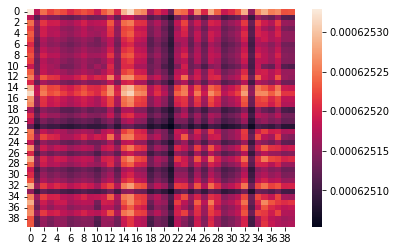

In [64]:
sns.heatmap(K_sign)

In [42]:
np.sign(np.array([[0,-1, 0.8], [0.0, -0.8, 1]]))

array([[ 0., -1.,  1.],
       [ 0., -1.,  1.]])

After simulation

In [13]:
with open(f'../sign_test_l2_0.75_s2_0.2_p2_0.5.pkl', 'rb') as f:
    sign_data_power = pickle.load(f)
sign_data_power.head()

,alpha,rw_weight,rw_signed,rw_abs,rw_binary,Bonferroni,Tensor
0,0.001000,0.001667,0.084000,0.294667,0.001000,0.000667,0.092000
1,0.001991,0.003333,0.127667,0.376333,0.002667,0.001333,0.132667
2,0.002982,0.004000,0.153667,0.427667,0.004333,0.001667,0.161333
3,0.003973,0.006000,0.180333,0.467000,0.007000,0.003333,0.185667
4,0.004964,0.007000,0.197000,0.504667,0.008000,0.005000,0.205333


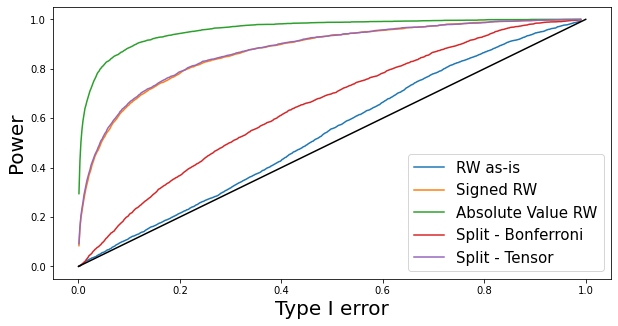

In [15]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

ax.plot(sign_data_power['alpha'].iloc[::2],sign_data_power['rw_weight'].iloc[::2], label = 'RW as-is')
ax.plot(sign_data_power['alpha'].iloc[::2],sign_data_power['rw_signed'].iloc[::2], label = 'Signed RW')
ax.plot(sign_data_power['alpha'].iloc[::2],sign_data_power['rw_abs'].iloc[::2], label = 'Absolute Value RW')
ax.plot(sign_data_power['alpha'].iloc[::2],sign_data_power['Bonferroni'].iloc[::2], label = 'Split - Bonferroni ')
ax.plot(sign_data_power['alpha'].iloc[::2],sign_data_power['Tensor'].iloc[::2], label = 'Split - Tensor')
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.legend(fontsize = 15)

# Weight analysis

In [11]:
with open(f'../weight_test_n1_20_n_1_20_nnode_1_20_nnode_2_20_l2_0.7_s2_0.3_k1_4_k2_3.5.pkl', 'rb') as f:
    weigh_data_power = pickle.load(f)
weigh_data_power.head()

,alpha,rw_weight,propagation,pyramid,sp,rw_binary,wloa,wl,wwl
0,0.001000,0.653667,0.082000,0.006000,0.663333,0.203667,0.100667,0.078000,0.103667
1,0.001991,0.737333,0.118333,0.012000,0.741000,0.271000,0.143333,0.115000,0.143667
2,0.002982,0.779000,0.143333,0.016667,0.789000,0.323333,0.170667,0.140333,0.171333
3,0.003973,0.809333,0.167333,0.019000,0.818667,0.357667,0.193667,0.160667,0.192000
4,0.004964,0.832667,0.186000,0.019667,0.842000,0.388333,0.214333,0.180667,0.211333


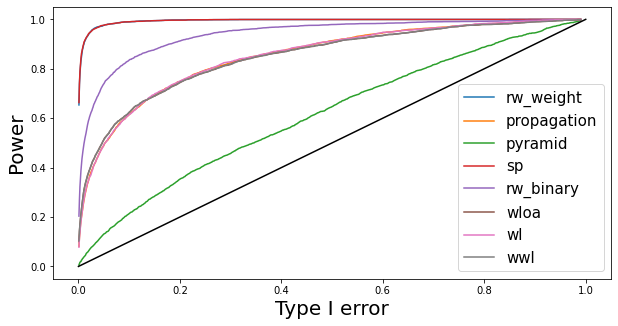

In [12]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

for k in weigh_data_power.columns:
    if k == 'alpha':
        continue
    ax.plot(weigh_data_power['alpha'], weigh_data_power[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.legend(fontsize = 15)

# Weight analysis attributes

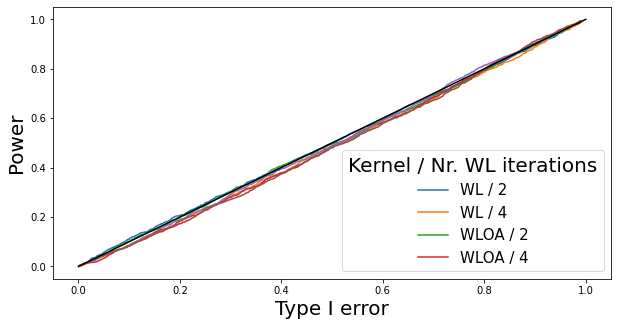

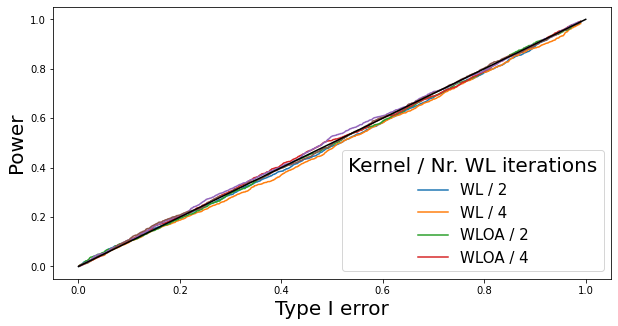

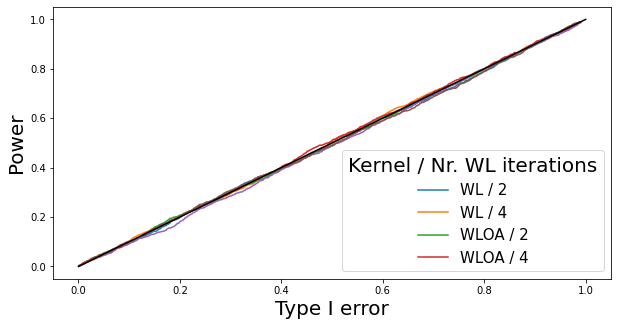

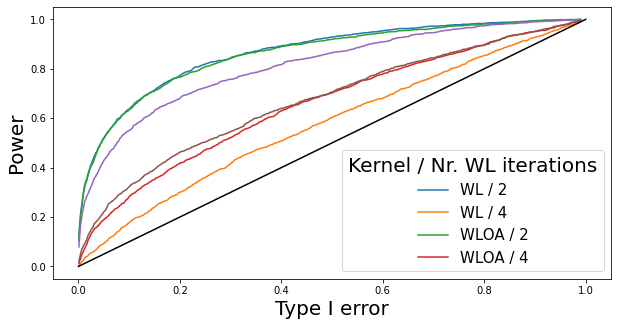

In [61]:
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.00038_s_0.01'
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.0002_s_0.01'
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.00038_s_0.015'
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.0002_s_0.015'
#path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_m_0.00038_s_0.01'
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_m_0.0002_s_0.01'
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_m_0.00038_s_0.015'
# path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_m_0.0002_s_0.015'

path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.00038_s_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weigha_attr_data_power1 = pickle.load(f)


path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.0002_s_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weigha_attr_data_power2 = pickle.load(f)

path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_m_0.00038_s_0.015'
with open(f'../{path}.pkl', 'rb') as f:
    weigha_attr_data_power3 = pickle.load(f)

path = 'weight_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_m_0.0002_s_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weigha_attr_data_power4 = pickle.load(f)


fig, ax = plt.subplots(1,1, figsize = (10,5))

# legend_title = 'Bin width'
# legend_labels = ['0.1', '0.01', '0.001', '0.0001']

# legend_title = 'kernel'
# legend_labels = ['RW only p', 'RW p and q', 'Binary RW only p', 'Binary RW p and q', 'SP']

# legend_title = 'd / with labels'
# legend_labels = ['2 / No', '2', '6 / No', '6', '10 / No', '10']

legend_title = 'Kernel / Nr. WL iterations'
legend_labels = ['WL / 2', 'WL / 4', 'WLOA / 2', 'WLOA / 4']

# cols = weigha_attr_data_power1.columns
# cols = ['propagation0.1', 'propagation0.01', 'propagation0.001', 'propagation0.0001']
# cols = ['wwl0.1', 'wwl0.01', 'wwl0.001', 'wwl0.0001']
cols = ['pyramid2wlab', 'pyramid2', 'pyramid6wlab', 'pyramid6', 'pyramid10wlab', 'pyramid10']
# cols = ['wl2', 'wl4', 'wloa2', 'wloa4']
# cols = ['rw_weight', 'rw_weight2', 'rw_binary', 'rw_binary2', 'sp']
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weigha_attr_data_power1['alpha'], weigha_attr_data_power1[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
# ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $m_1 = 0.00038$ vs $m_2 = 0.00038$, $s_1 = 0.01$ vs $s_2 = 0.01$", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weigha_attr_data_power2['alpha'], weigha_attr_data_power2[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
# ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $m_1 = 0.00038$ vs $m_2 = 0.0002$, $s_1 = 0.01$ vs $s_2 = 0.01$", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weigha_attr_data_power3['alpha'], weigha_attr_data_power3[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
# ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $m_1 = 0.00038$ vs $m_2 = 0.0002$, $s_1 = 0.01$ vs $s_2 = 0.015$", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')


fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weigha_attr_data_power4['alpha'], weigha_attr_data_power4[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
# ax.set_title(r"$k_{1}= 4$ vs $k_2 = 3.5$, $w_1 = 3000$ vs $w_2 = 3500$, $m_1 = 0.00038$ vs $m_2 = 0.00038$, $s_1 = 0.01$ vs $s_2 = 0.01$", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20,5))


for k in weigha_attr_data_power.columns:
    if k == 'alpha':
        continue
    ax.plot(weigha_attr_data_power['alpha'], weigha_attr_data_power[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.legend(fontsize = 15)

# WEIGHT SIGN

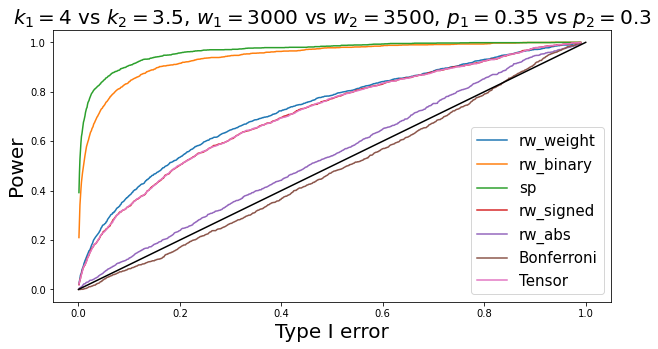

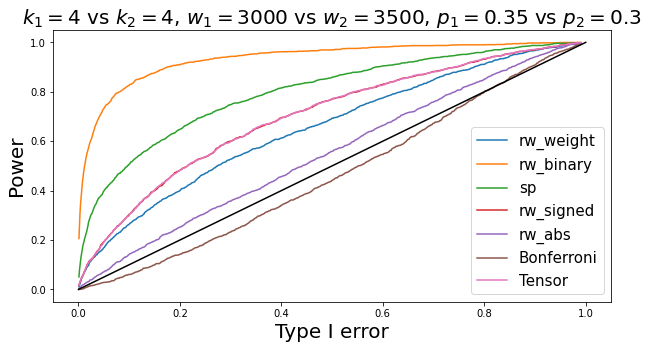

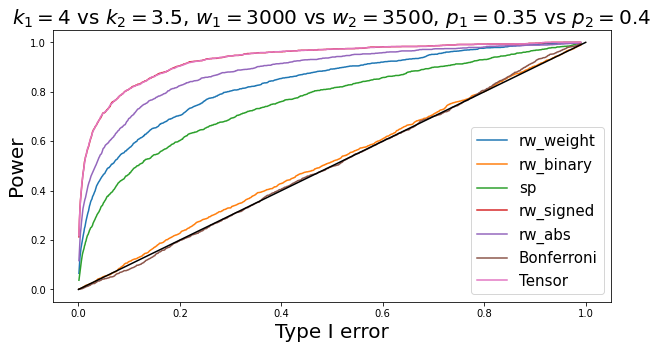

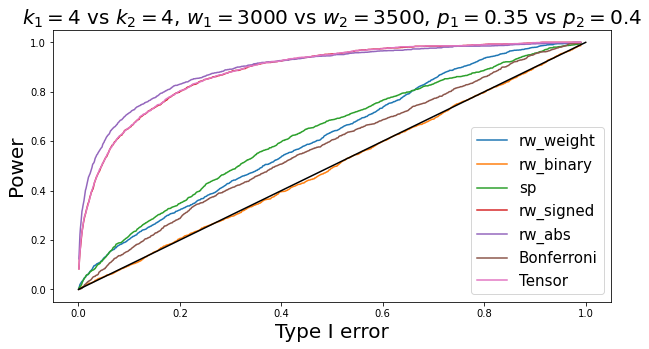

In [3]:


path = 'weight_sign_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_p1_0.35p2_0.3'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power1 = pickle.load(f)
weight_sign_data_power1.head()

path = 'weight_sign_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_p1_0.35p2_0.4'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power2 = pickle.load(f)
weight_sign_data_power2.head()

path = 'weight_sign_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_p1_0.35p2_0.3'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power3 = pickle.load(f)
weight_sign_data_power3.head()

path = 'weight_sign_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_p1_0.35p2_0.4'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power4 = pickle.load(f)
weight_sign_data_power4.head()


# cols = weight_sign_data_power.columns
# cols = ['propagation0.1', 'propagation0.01', 'propagation0.001', 'propagation0.0001']
# cols = ['wwl0.1', 'wwl0.01', 'wwl0.001', 'wwl0.0001']
# cols = ['pyramid2wlab', 'pyramid2', 'pyramid6wlab', 'pyramid6', 'pyramid10wlab', 'pyramid10']
# cols = ['wl2', 'wl4']
# cols = ['wloa2', 'wloa4']
cols = ['rw_weight',  'rw_binary', 'sp', 'rw_signed', 'rw_abs', 'Bonferroni', 'Tensor']

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power1['alpha'], weight_sign_data_power1[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 3.5$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.3$", fontsize = 20)
ax.legend(fontsize = 15)

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power2['alpha'], weight_sign_data_power2[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.3$", fontsize = 20)
ax.legend(fontsize = 15)

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power3['alpha'], weight_sign_data_power3[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 3.5$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.4$", fontsize = 20)
ax.legend(fontsize = 15)

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power4['alpha'], weight_sign_data_power4[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.4$", fontsize = 20)
ax.legend(fontsize = 15)

(999, 26)


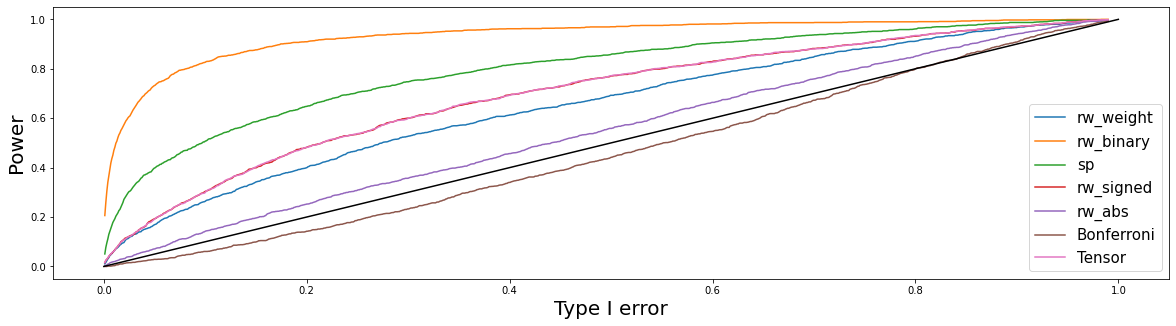

In [95]:

path = 'weight_sign_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_p1_0.35p2_0.4'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power = pickle.load(f)
weight_sign_data_power.head()

print(weight_sign_data_power.shape)

fig, ax = plt.subplots(1,1, figsize = (20,5))
# cols = weight_sign_data_power.columns
# cols = ['propagation0.1', 'propagation0.01', 'propagation0.001', 'propagation0.0001']
# cols = ['wwl0.1', 'wwl0.01', 'wwl0.001', 'wwl0.0001']
# cols = ['pyramid2wlab', 'pyramid2', 'pyramid6wlab', 'pyramid6', 'pyramid10wlab', 'pyramid10']
# cols = ['wl2', 'wl4']
# cols = ['wloa2', 'wloa4']
cols = ['rw_weight',  'rw_binary', 'sp', 'rw_signed', 'rw_abs', 'Bonferroni', 'Tensor']
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power['alpha'], weight_sign_data_power[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.legend(fontsize = 15)

# Weight Attribute Sign

In [4]:
path = 'sp_weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_4_p1_0.35_p2_0.3_l2_0.00038_s2_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    sp_weight_sign_data_power2 = pickle.load(f)


In [10]:
sp_weight_sign_data_power6.keys()

Index(['alpha', 'sp_n1e1', 'sp_abs_n1e1', 'sp_n2e1', 'sp_abs_n2e1', 'spe1',
       'sp_abse1', 'sp_n1e2', 'sp_abs_n1e2', 'sp_n2e2', 'sp_abs_n2e2', 'spe2',
       'sp_abse2', 'sp_n1e3', 'sp_abs_n1e3', 'sp_n2e3', 'sp_abs_n2e3', 'spe3',
       'sp_abse3'],
      dtype='object')

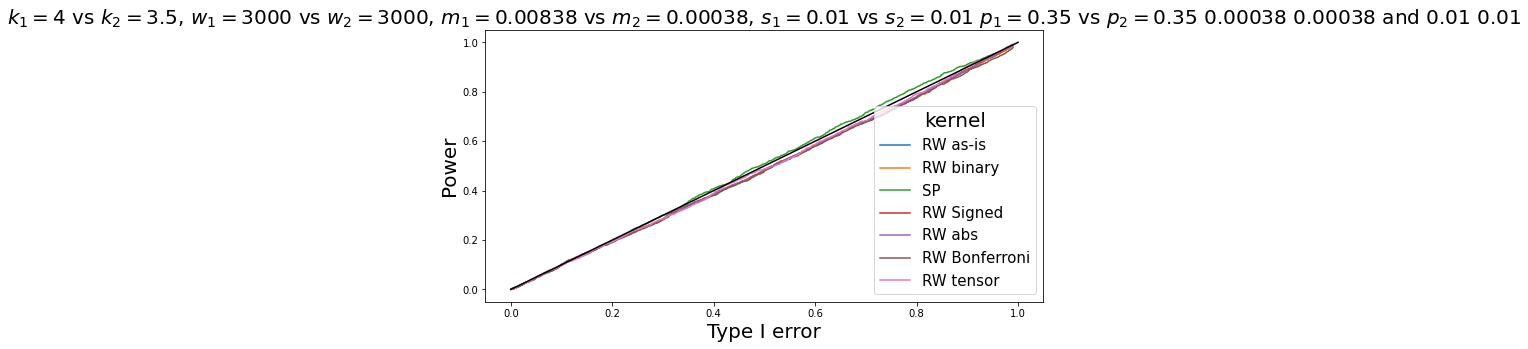

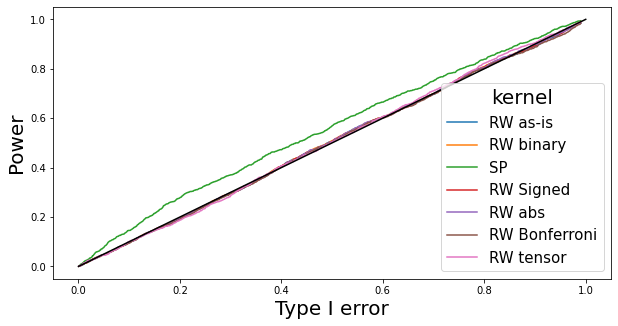

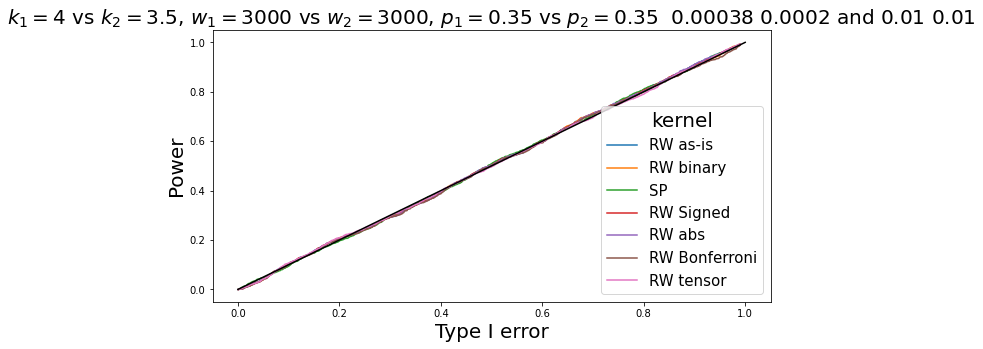

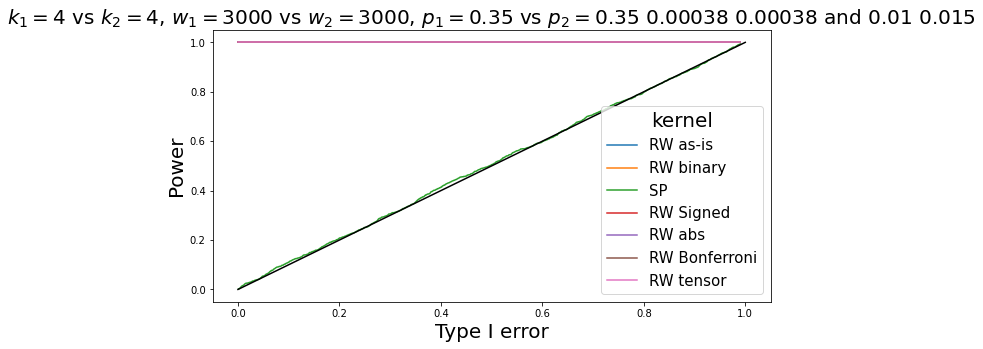

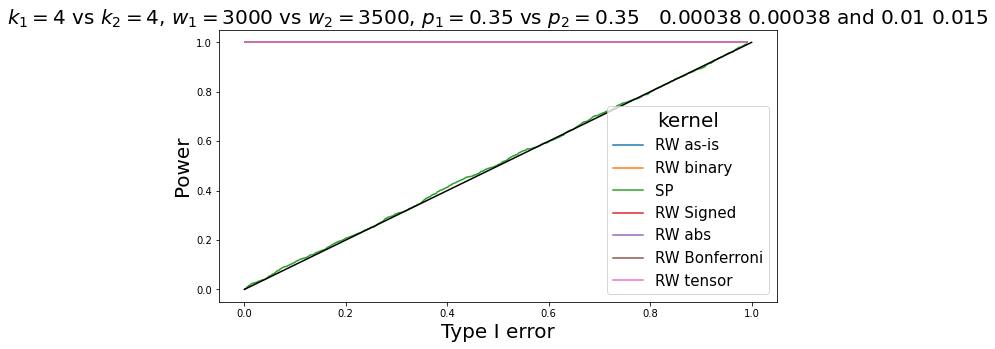

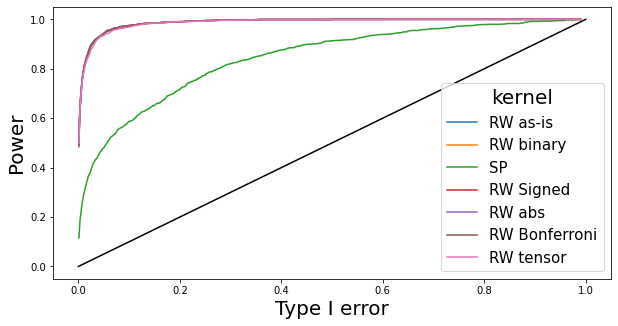

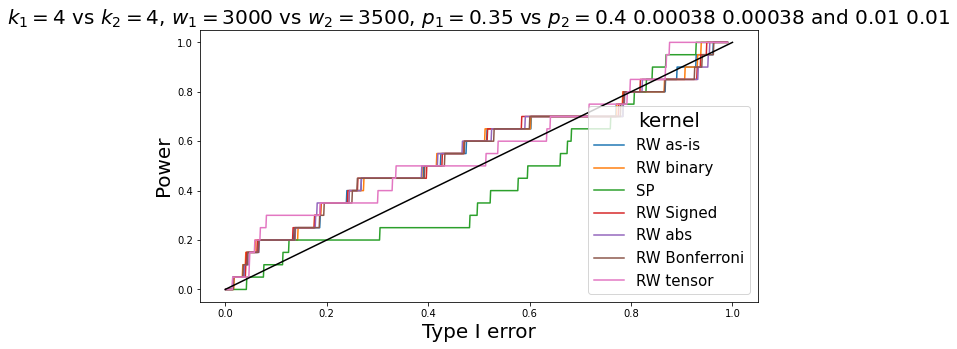

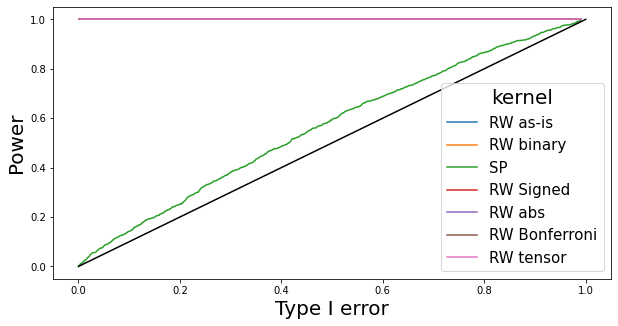

In [13]:


path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_3.5_p1_0.35_p2_0.35_l2_0.00038_s2_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_attr_data_power1 = pickle.load(f)

path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_4_p1_0.35_p2_0.3_l2_0.00038_s2_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power2 = pickle.load(f)
path = 'data/weight_sign/sp_weight_sign_attr_test_with_abs_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_4_p1_0.35_p2_0.3_l2_0.00038_s2_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    sp_weight_sign_data_power2 = pickle.load(f)
weight_sign_data_power2['sp'] = sp_weight_sign_data_power2['sp_n1e2']


path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_4_p1_0.35_p2_0.35_l2_0.0002_s2_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power3 = pickle.load(f)
weight_sign_data_power3.head()

path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_4_p1_0.35_p2_0.35_l2_0.00038_s2_0.015'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power4 = pickle.load(f)
weight_sign_data_power4.head()

path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3000_k1_4_k2_4_p1_0.35_p2_0.35_l2_0.00038_s2_0.015'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power5 = pickle.load(f)
weight_sign_data_power5.head()

path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_p1_0.35_p2_0.3_l2_0.0002_s2_0.012'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power6 = pickle.load(f)
weight_sign_data_power6.head()
path = 'data/weight_sign/sp_weight_sign_attr_test_with_abs_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_p1_0.35_p2_0.3_l2_0.0002_s2_0.012'
with open(f'../{path}.pkl', 'rb') as f:
    sp_weight_sign_data_power6 = pickle.load(f)
weight_sign_data_power6['sp'] = sp_weight_sign_data_power6['sp_n1e2']


path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_p1_0.35_p2_0.35_l2_0.00038_s2_0.01'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power7 = pickle.load(f)
weight_sign_data_power7.head()

path = 'data/weight_sign/weight_sign_attr_test_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_p1_0.35_p2_0.35_l2_0.00038_s2_0.015'
with open(f'../{path}.pkl', 'rb') as f:
    weight_sign_data_power8 = pickle.load(f)
path = 'data/weight_sign/sp_weight_sign_attr_test_with_abs_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_4_p1_0.35_p2_0.35_l2_0.00038_s2_0.015'
with open(f'../{path}.pkl', 'rb') as f:
    sp_weight_sign_data_power8 = pickle.load(f)
weight_sign_data_power8['sp'] = sp_weight_sign_data_power8['sp_n1e2']


# cols = weight_sign_data_power.columns
# cols = ['propagation0.1', 'propagation0.01', 'propagation0.001', 'propagation0.0001']
# cols = ['wwl0.1', 'wwl0.01', 'wwl0.001', 'wwl0.0001']
# cols = ['pyramid2wlab', 'pyramid2', 'pyramid6wlab', 'pyramid6', 'pyramid10wlab', 'pyramid10']
# cols = ['wl2', 'wl4', 'wloa2', 'wloa4' ,'wwl0.01']
# cols = ['wloa2', 'wloa4']
cols = ['rw_weight',  'rw_binary', 'sp', 'rw_signed', 'rw_abs', 'Bonferroni', 'Tensor']


# legend_title = 'Bin width'
# legend_labels = ['0.1', '0.01', '0.001', '0.0001']

legend_title = 'kernel'
legend_labels = ['RW as-is', 'RW binary', 'SP', 'RW Signed', 'RW abs', 'RW Bonferroni', 'RW tensor']

# legend_title = 'd / with labels'
# legend_labels = ['2 / No', '2 / Yes', '6 / No', '6 / Yes', '10 / No', '10 / Yes']

# legend_title = 'Kernel / Nr. WL itr.'
# legend_labels = ['WL / 2', 'WL / 4', 'WLOA / 2', 'WLOA / 4', 'WWL / 2']



fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_attr_data_power1['alpha'], weight_sign_attr_data_power1[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 3.5$, $w_1 = 3000$ vs $w_2 = 3000$, $m_1 = 0.00838$ vs $m_2 = 0.00038$, $s_1 = 0.01$ vs $s_2 = 0.01$ $p_1 = 0.35$ vs $p_2 = 0.35$ 0.00038 0.00038 and 0.01 0.01", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power2['alpha'], weight_sign_data_power2[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
# ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3000$, $p_1 = 0.35$ vs $p_2 = 0.3$ 0.00038 0.00038 and 0.01 0.01", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')


fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power3['alpha'], weight_sign_data_power3[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 3.5$, $w_1 = 3000$ vs $w_2 = 3000$, $p_1 = 0.35$ vs $p_2 = 0.35$  0.00038 0.0002 and 0.01 0.01", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')


fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power4['alpha'], weight_sign_data_power4[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3000$, $p_1 = 0.35$ vs $p_2 = 0.35$ 0.00038 0.00038 and 0.01 0.015", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')


fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power5['alpha'], weight_sign_data_power5[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.35$   0.00038 0.00038 and 0.01 0.015", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')


fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power6['alpha'], weight_sign_data_power6[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
# ax.set_title(r"$k_{1}= 4$ vs $k_2 = 3.5$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.3$  0.00038 0.0002 and 0.01 0.012", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power7['alpha'], weight_sign_data_power7[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.4$ 0.00038 0.00038 and 0.01 0.01", fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_data_power8['alpha'], weight_sign_data_power8[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
#ax.set_title(r"$k_{1}= 4$ vs $k_2 = 4$, $w_1 = 3000$ vs $w_2 = 3500$, $p_1 = 0.35$ vs $p_2 = 0.35$ 0.00038 0.00038 and 0.01 0.015 " , fontsize = 20)
ax.legend(legend_labels, title = legend_title,fontsize = 15, title_fontsize = 20, loc='lower right')

# Weight attribute sign tensor

In [11]:
path = 'sp_weight_sign_attr_test_with_abs_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.5_p1_0.35_p2_0.3_l2_0.0002_s2_0.012'
with open(f'../data/weight_sign/{path}.pkl', 'rb') as f:
    weight_sign_attr_test_with_abs_1 = pickle.load(f)

In [11]:
weight_sign_attr_test_with_abs_1.columns

Index(['alpha', 'sp_n1e1', 'sp_abs_n1e1', 'sp_n2e1', 'sp_abs_n2e1', 'spe1',
       'sp_abse1', 'sp_n1e2', 'sp_abs_n1e2', 'sp_n2e2', 'sp_abs_n2e2', 'spe2',
       'sp_abse2', 'sp_n1e3', 'sp_abs_n1e3', 'sp_n2e3', 'sp_abs_n2e3', 'spe3',
       'sp_abse3'],
      dtype='object')

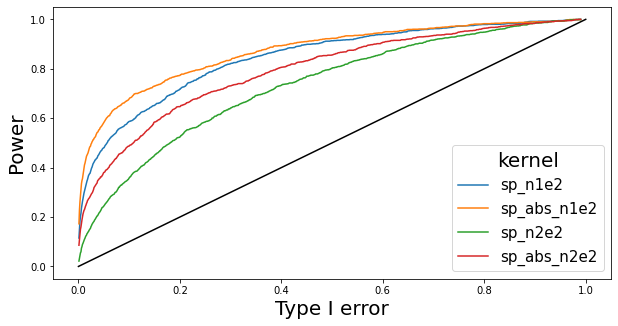

In [12]:
# cols = weight_sign_data_power.columns
# cols = ['propagation0.1', 'propagation0.01', 'propagation0.001', 'propagation0.0001', 'propagation1e-05']
# cols = ['propagation_abs0.1', 'propagation_abs0.01', 'propagation_abs0.001', 'propagation_abs0.0001', 'propagation_abs1e-05']
# cols = ['wwl0.1', 'wwl0.01', 'wwl0.001', 'wwl0.0001']
# cols = ['pyramid2wlab', 'pyramid2', 'pyramid6wlab', 'pyramid6', 'pyramid10wlab', 'pyramid10']
# cols = ['wl2', 'wl4', 'wloa2', 'wloa4' ,'wwl0.01', 'wl_abs2', 'wl_abs4', 'wloa_abs2', 'wloa_abs4' ,'wwl_abs0.01']
# cols = ['wl2', 'wl4', 'wl_abs2', 'wl_abs4']
# cols = ['wloa2', 'wloa4']
# cols = ['rw_weight',  'rw_binary', 'sp', 'rw_signed', 'rw_abs', 'Bonferroni', 'Tensor']
cols = ['sp_n1e1', 'sp_abs_n1e1', 'sp_n2e1', 'sp_abs_n2e1', 'spe1',
       'sp_abse1', 'sp_n1e2', 'sp_abs_n1e2', 'sp_n2e2', 'sp_abs_n2e2', 'spe2',
       'sp_abse2', 'sp_n1e3', 'sp_abs_n1e3', 'sp_n2e3', 'sp_abs_n2e3', 'spe3',
       'sp_abse3']

cols = ['sp_n1e1', 'sp_abs_n1e1', 'sp_n2e1', 'sp_abs_n2e1']
cols = ['sp_n1e2', 'sp_abs_n1e2', 'sp_n2e2', 'sp_abs_n2e2']

# legend_title = 'Bin width'
# legend_labels = ['0.1', '0.01', '0.001', '0.0001']

legend_title = 'kernel'
legend_labels = ['RW as-is', 'RW binary', 'SP', 'RW Signed', 'RW abs', 'RW Bonferroni', 'RW tensor']

# legend_title = 'd / with labels'
# legend_labels = ['2 / No', '2 / Yes', '6 / No', '6 / Yes', '10 / No', '10 / Yes']

# legend_title = 'Kernel / Nr. WL itr.'
# legend_labels = ['WL / 2', 'WL / 4', 'WLOA / 2', 'WLOA / 4', 'WWL / 2']



fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(weight_sign_attr_test_with_abs_1['alpha'], weight_sign_attr_test_with_abs_1[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.legend(cols, title = legend_title, fontsize = 15, title_fontsize = 20, loc='lower right')


wl node labled as return

In [20]:
path = 'wl_weight_sign_attr_test_with_abs_n1_20_n_1_20_v_1_20_v_2_20_s2_3500_k1_4_k2_3.9_p1_0.35_p2_0.3_l2_0.0002_s2_0.012'
with open(f'../data/weight_sign/{path}.pkl', 'rb') as f:
    wl_weight_sign_attr_test_with_abs_1 = pickle.load(f)
wl_weight_sign_attr_test_with_abs_1.columns

Index(['alpha', 'wl_abs2_n1', 'wloa_abs2_n1', 'wl2_n1', 'wloa2_n1',
       'wl_abs2_n2', 'wloa_abs2_n2', 'wl2_n2', 'wloa2_n2', 'wl_abs4_n1',
       'wloa_abs4_n1', 'wl4_n1', 'wloa4_n1', 'wl_abs4_n2', 'wloa_abs4_n2',
       'wl4_n2', 'wloa4_n2', 'wwl_abs0.1_n1', 'wwl0.1_n1', 'wwl_abs0.1_n2',
       'wwl0.1_n2', 'wwl_abs0.01_n1', 'wwl0.01_n1', 'wwl_abs0.01_n2',
       'wwl0.01_n2', 'wwl_abs0.001_n1', 'wwl0.001_n1', 'wwl_abs0.001_n2',
       'wwl0.001_n2', 'wwl_abs0.0001_n1', 'wwl0.0001_n1', 'wwl_abs0.0001_n2',
       'wwl0.0001_n2', 'wwl_abs1e-05_n1', 'wwl1e-05_n1', 'wwl_abs1e-05_n2',
       'wwl1e-05_n2'],
      dtype='object')

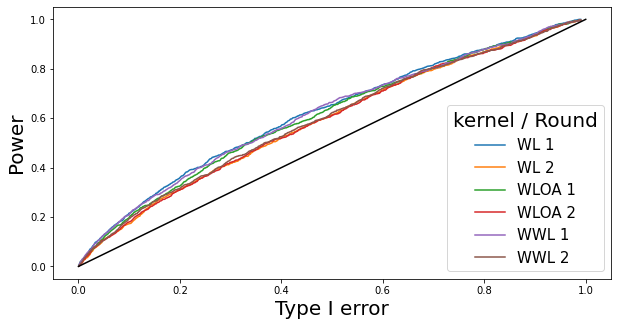

In [24]:
cols = wl_weight_sign_attr_test_with_abs_1.columns
# cols = ['propagation0.1', 'propagation0.01', 'propagation0.001', 'propagation0.0001', 'propagation1e-05']
# cols = ['propagation_abs0.1', 'propagation_abs0.01', 'propagation_abs0.001', 'propagation_abs0.0001', 'propagation_abs1e-05']
# cols = ['wwl0.1', 'wwl0.01', 'wwl0.001', 'wwl0.0001']
# cols = ['pyramid2wlab', 'pyramid2', 'pyramid6wlab', 'pyramid6', 'pyramid10wlab', 'pyramid10']
# cols = ['wl2', 'wl4', 'wloa2', 'wloa4' ,'wwl0.01', 'wl_abs2', 'wl_abs4', 'wloa_abs2', 'wloa_abs4' ,'wwl_abs0.01']
# cols = ['wl2', 'wl4', 'wl_abs2', 'wl_abs4']
# cols = ['wloa2', 'wloa4']
# cols = ['rw_weight',  'rw_binary', 'sp', 'rw_signed', 'rw_abs', 'Bonferroni', 'Tensor']
# cols = ['sp_n1e1', 'sp_abs_n1e1', 'sp_n2e1', 'sp_abs_n2e1', 'spe1',
#        'sp_abse1', 'sp_n1e2', 'sp_abs_n1e2', 'sp_n2e2', 'sp_abs_n2e2', 'spe2',
#        'sp_abse2', 'sp_n1e3', 'sp_abs_n1e3', 'sp_n2e3', 'sp_abs_n2e3', 'spe3',
#        'sp_abse3']

# cols = ['sp_n1e1', 'sp_abs_n1e1', 'sp_n2e1', 'sp_abs_n2e1']
# cols = ['sp_n1e2', 'sp_abs_n1e2', 'sp_n2e2', 'sp_abs_n2e2']

cols = ['wl2_n1','wl2_n2', 'wloa2_n1','wloa2_n2','wwl0.1_n1','wwl0.1_n2',  ]

# legend_title = 'Bin width'
# legend_labels = ['0.1', '0.01', '0.001', '0.0001']

legend_title = 'kernel'
#legend_labels = ['RW as-is', 'RW binary', 'SP', 'RW Signed', 'RW abs', 'RW Bonferroni', 'RW tensor']

# legend_title = 'd / with labels'
# legend_labels = ['2 / No', '2 / Yes', '6 / No', '6 / Yes', '10 / No', '10 / Yes']

# legend_title = 'Kernel / Nr. WL itr.'
# legend_labels = ['WL / 2', 'WL / 4', 'WLOA / 2', 'WLOA / 4', 'WWL / 2']

legend_title = 'kernel / Round'
legend_labels = ['WL 1', 'WL 2', 'WLOA 1', 'WLOA 2', 'WWL 1', 'WWL 2']


fig, ax = plt.subplots(1,1, figsize = (10,5))
for k in cols:
    if k == 'alpha':
        continue
    ax.plot(wl_weight_sign_attr_test_with_abs_1['alpha'], wl_weight_sign_attr_test_with_abs_1[k], label = k)
ax.plot([0,1], [0,1], color = 'black')
ax.set_ylabel("Power", fontsize = 20)
ax.set_xlabel("Type I error", fontsize = 20)
ax.legend(legend_labels, title = legend_title, fontsize = 15, title_fontsize = 20, loc='lower right')
